## Simulation Analysis

1. True population density analysis (model precision and accuracy) of entire data set. Between total hits and actual hits.

2. Density estimation changes between multiple combinations (animals, paths, camera, uav_paths, uav_speed, bias)

Loading in simulations and packages ..

In [1]:
#clear environments
rm(list=ls())

suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
library(geosphere)
suppressMessages(library(reshape2))
library(ggthemes)

mydir = "../Data/Simulations/HPC2/"
all_sims = list.files(path=mydir, pattern="*.csv", full.names=TRUE) %>%
                map_df(~fread(.))


current_sims <- split(all_sims,rep(1:1000,each=1344))
#current_sims

# Timesteps of simulation runs
timestep <- 10000

### Summary Stats

In [2]:
# Overlap calculated by calculating the number of average timesteps 
# necessary to traverse image width - this dependent on camera (FOV), speed(1,2) 
# Area covered by each camera appended to simulation data


garmin_area <- ((113*83)*timestep)
sony_area <- ((113*75)*timestep)
nadir_area <- ((164*109)*timestep)


Camera <- c("garmin", "garmin", "sony", "sony", "nadir", "nadir")
Speed <-c(1, 2, 1, 2, 1, 2)
cam_area <- c(garmin_area, sony_area, nadir_area)

G1 <- floor(113/9)
G2 <- floor(113/25.5)
S1 <- floor(75/9)
S2 <- floor(75/25.5)
N1 <- floor(109/9)
N2 <- floor(109/25.5)

Area_km <- c(((garmin_area/G1)/1000), ((garmin_area/G2)/1000), ((sony_area/S1)/1000), 
             ((sony_area/S2)/1000), ((nadir_area/N1)/1000), ((nadir_area/N2)/1000)) # Converting to kilometres2

cam_table <- data.frame(Camera, Speed, Area_km)


unique_cams = unique(all_sims$Camera)
unique_speed = c(1, 2)

all_sims = merge(all_sims, cam_table)

In [3]:
# Number of combinations of variables: 1344
no_runs <- length(current_sims)
no_simulations <- no_runs*1344

# Hit histograms

Actual_hit_plot <- ggplot(data = all_sims) + 
                      geom_histogram(aes(x=Actual_hits), fill = 'red',  binwidth = 0.5) 

Total_hit_plot <- ggplot(data = all_sims) +
                      geom_histogram(aes(x=Total_hits), fill = 'blue', position = "identity", binwidth = 0.5)

ave_encounter_rate <- mean(all_sims$Actual_hits) # Taking into account all those 0 values
common_e_rate <- median(all_sims$Actual_hits)

# Proportion of hits vs. non-hits
non_zero_sims <- subset(all_sims, all_sims$Actual_hits > 0)
Prop_hits <- nrow(non_zero_sims)/nrow(all_sims)
#Prop_hits

#Actual_hit_plot

### Model Precision and Accuracy

Model accuracy of entire datset means that we calculate the density of each simulation and compare it to the mean density of all simulations (true mean density). The standard deviation from the true mean density informs us of model accuracy.

**True simulation density then is not the actual density of animals in that area but rather the mean calculated density from x number of simulations. I would have initially assumed the true simulation density to be 1 (there's one animal in the simulation)** but that is never really the case when encounters are expressed as a ratio of area.

Must first calculate area covered in each simulation (fix in simulation later)

In [4]:
# Density Calculations

calcDensity <- function(z, A){
  # Calculate density using ideal gas model from capture rate and survey area covered
  # z : The number of encounters/captures.
  # A : Area covered by sensor per unit time.
  
  # Double check parameters: will be < 0 or double
  #if(z < 0 | !is.numeric(z)) stop("Number of individuals must be a positive number")
  #if (A <= 0 | !is.numeric(A)) stop("Area, A, must be a positive number.")
    
  # Calculate density
  return(D <- z/A)
}



# Calculate density per simulation
Density_km <- calcDensity(all_sims$Actual_hits, all_sims$Area_km)
#Density_km
False_Density_km <- calcDensity(all_sims$Total_hits, all_sims$Area_km)

all_sims <- cbind(all_sims, Density_km)
all_sims <- cbind(all_sims, False_Density_km)

In [5]:
#all_sims[1,]
#all_sims[1345,]
#all_sims[2689,]

In [6]:
true_sim_den <- mean(all_sims$Density_km) # mean
standard_deviation <- sd(all_sims$Density_km) # distribution


all_sim_den <- ggplot(data = all_sims) + 
                geom_histogram(aes(x=Density_km), fill = 'skyblue1') +
                xlab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                ylab('Frequency') +
                theme_bw()
all_sim_den <- all_sim_den + geom_vline(xintercept = true_sim_den, color = 'darkblue')
all_sim_den <- all_sim_den + geom_vline(xintercept = true_sim_den - (standard_deviation/2), color = 'darkblue', linetype="dotted")
all_sim_den <- all_sim_den + geom_vline(xintercept = true_sim_den + (standard_deviation/2), color = 'darkblue', linetype="dotted")


#pdf(file = paste("../Results/all_sims_density.pdf"))
#print(all_sim_den)
#dev.off()

f_den <- mean(all_sims$False_Density_km)
f_sd <- sd(all_sims$False_Density_km)

all_sim_fake_den <- ggplot(data = all_sims) + 
                geom_histogram(aes(x=False_Density_km), fill = 'skyblue3') +
                xlab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                ylab('Frequency') +
                theme_bw()
all_sim_fake_den <- all_sim_fake_den + geom_vline(xintercept = f_den, color = 'darkblue')
all_sim_fake_den <- all_sim_fake_den + geom_vline(xintercept = f_den - (f_sd/2), color = 'darkblue', linetype="dotted")
all_sim_fake_den <- all_sim_fake_den + geom_vline(xintercept = f_den + (f_sd/2), color = 'darkblue', linetype="dotted")
#all_sim_fake_den

f_den
f_sd
#true_sim_den
#standard_deviation

[1] 6.758396e-05

[1] 0.0003164569

In [7]:
#dist_err <- sapply(all_sims$Density_km, function(x) x - true_sim_den)
#all_sims <- cbind(all_sims, dist_err)

In [8]:
dist_den <- ggplot(data = all_sims, aes(x = "", y = dist_err)) + 
            geom_boxplot() +
            xlab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                ylab('Frequency') +
                theme_bw()
all_sim_ap <- summary(all_sims$Density_km)
#median(all_sims$dist_err)
#head(all_sims$Density_km)
#head(all_sims$dist_err)

ap_percent <- (all_sim_ap[3]/all_sim_ap[6])*100
all_sim_ap


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 1.935e-05 0.000e+00 2.303e-03 

#### Combination Analysis

In [9]:
per_sim_density <- function(df){
  
  # Calculate density for each simulation and add
  Density_km <- calcDensity(df$Actual_hits, df$Area_km)
  False_Density_km <- calcDensity(df$Total_hits, df$Area_km)
  
  df <- cbind(df, Density_km)
  df <- cbind(df, False_Density_km)
  
  return(df)
}


for(i in 1:length(current_sims)){
    unique_cams = unique(current_sims[[i]]$Camera)
    unique_speed = c(1, 2)
    current_sims[[i]] = merge(current_sims[[i]], cam_table)
    current_sims[[i]] <- per_sim_density(current_sims[[i]])
}



#calcArea(current_sims[[1]])
#current_sims[[6]]

In [10]:
per_density_table <- function(df){
  ##### Calculate density for each individual combination ####
  den_vect <- subset(df, select = ('Density_km'))
  #print(den_vect)
  return(den_vect)
}

den_table <- c(1:1344)
for(i in current_sims){
  t <- per_density_table(i)
  den_table <- cbind(den_table, t)
}



combo_med_dist <- matrix(0,nrow=1344, ncol=1000)
for(i in 1:length(den_table)){
    #For each combination - find out how far each value is from the mean 
    row <- as.numeric(den_table[i,2:1001])
    den_mean <- mean(row)
    med_dist <- sapply(row, function(x) (den_mean) - x)
    combo_med_dist[i,] <- med_dist
}

#median(combo_med_dist[2,])
combo_med <- c() 
combo_percent <- c()
for(i in 1:1344){
    #For each combination - find out median distance from mean
    row <- median(combo_med_dist[i,])
    max <- max(combo_med_dist[i,])
    combo_med <- c(combo_med, row)
    percent <- (combo_med/max)*100
    combo_percent <- c(combo_percent, percent)
 }                      
                       
#combo_med
                       
### Analyze density table for mean, sd and cv for all runs of each combination ###
combo_mean <- apply(den_table, 1, function(x) mean(x))
combo_sd <- apply(den_table, 1, function(x) sd(x))

combo_stats <- cbind(combo_mean, combo_sd)
combo_stats <- cbind(combo_stats, combo_med)
combo_stats <- cbind(combo_stats, combo_percent)

combo_cv <- apply(combo_stats, 1, function(x) (x[2]/ x[1])*100)
combo_stats <- cbind(combo_stats, combo_cv)
     
# Remove NaNs
#is.nan.data.frame <- function(x)
#do.call(cbind, lapply(x, is.nan))

combo_stats[is.na(combo_stats)] <- 0
combo_stats[is.nan(combo_stats)] <- 0
combo_stats[!is.finite(combo_stats)] <- 0  

#combo_stats

Warning message in cbind(combo_stats, combo_percent):
“number of rows of result is not a multiple of vector length (arg 2)”

In [14]:
mean(as.numeric(den_table[1,]))

[1] 0.001252463

In [12]:
den_table

den_table,Density_km,Density_km.1,Density_km.2,Density_km.3,Density_km.4,Density_km.5,Density_km.6,Density_km.7,Density_km.8,⋯,Density_km,Density_km.1,Density_km.2,Density_km.3,Density_km.4,Density_km.5,Density_km.6,Density_km.7,Density_km.8,Density_km.9
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,⋯,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908
2,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0001279454,0.0002558908,0.0002558908,⋯,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0003838362
3,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,⋯,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,⋯,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
5,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,⋯,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0003838362
6,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,⋯,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908
7,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,⋯,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
8,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,⋯,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
9,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,⋯,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908,0.0002558908


In [13]:
# How much does mean density differ among flights? 
# You have done this above when looking at mean density differing among all simulations -
# This suggests little within flight variation
# hist(combo_mean)

# Does the variation within flights differ among flights?
# hist(combo_sd)
# Nope

#hist(combo_cv)
# Coefficient of variation indicates some big outliers - should investigate

all_com <- cbind(current_sims[[1]][1:6,], combo_stats)
#non_zero_com <- all_com[apply(all_com[,-1], 1, function(x) !all(x==0)),]


#all_com

all_com_mean <- summary(all_com$combo_mean)
all_com_cv <- summary(all_com$combo_cv)

#outliers <- sum(all_com$combo_cv > 0) # 1255 have no cv, 89 do.
#outliers_pos <- which(all_com$combo_cv > 0)

# Subset sims with a higher variation
#out_df <- all_com[outliers_pos,]
#out_df
#out_df - A lot of them are birds which travel faster
#all_com_mean
#all_com_cv

all_com_ap <- (all_com_mean[3]/all_com_mean[6])*100
#all_com_ap

true_combo_den <-  mean(all_com$combo_mean)
combo_sd <- sd(all_com$combo_mean)

all_com_den <- ggplot(data = all_com) + 
                geom_histogram(aes(x=combo_mean), fill = 'skyblue1') +
                xlab(expression(paste("Mean Density(per ", km^2,")", sep=" "))) +
                ylab('Frequency') +
                theme_bw()
all_com_den <- all_sim_den + geom_vline(xintercept = true_combo_den, color = 'darkblue')
all_com_den <- all_sim_den + geom_vline(xintercept = true_combo_den - (combo_sd/2), color = 'darkblue', linetype="dotted")
all_com_den <- all_sim_den + geom_vline(xintercept = true_combo_den + (combo_sd/2), color = 'darkblue', linetype="dotted")

min_combo <- all_com[which.min(all_com$Density_km),]
min_combo

max_combo <- all_com[which.max(all_com$Density_km),]
max_combo

Camera,Speed,Animal,Animal_path,UAV_path,Bias,Total_hits,Actual_hits,Area_km,Density_km,False_Density_km,combo_mean,combo_sd,combo_med,combo_percent,combo_cv
<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
garmin,1,reef,straight,figure8,yes,0,0,7815.833,0,0,0.002997003,0.09482093,0,-1.936799,3163.858


Camera,Speed,Animal,Animal_path,UAV_path,Bias,Total_hits,Actual_hits,Area_km,Density_km,False_Density_km,combo_mean,combo_sd,combo_med,combo_percent,combo_cv
<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
garmin,1,reef,straight,lawnmower,yes,5,2,7815.833,0.0002558908,0.000639727,0.001252463,0.03159896,-2.175072e-06,-1.7294,2522.945


In [14]:
# Dplyr subset by diffferent categories and compare model precision and accuracy

animal <- all_sims %>% 
            group_by(Animal) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))


animal_path <- all_sims %>% 
            group_by(Animal_path) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))


camera <- all_sims %>% 
            group_by(Camera) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))


uav_path <- all_sims %>% 
            group_by(UAV_path) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))


speed <- all_sims %>% 
            group_by(Speed) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))

bias_animals <- c('reef', 'nurse', 'whale_shark', 'ray', 'manatee')
bias_all_sims <- subset(all_sims, all_sims$Animal == bias_animals)
bias <- bias_all_sims %>% 
            group_by(Bias) %>%
                summarise(mean_den = mean(Density_km),
                          SD = sd(Density_km))


In [15]:
calc_med_dist <- function(col){
    # Intake density vector and find the median distance from mean as a percentage
    col_mean <- mean(col)
    dists <- sapply(col, function(x) (col_mean) - x)
    max_dist <- max(dists)
    median_dist <- median(dists)
    percent <- (median_dist/ max_dist)*100
    return(percent)
}
                    
calc_cv <- function(df){
    # Each variable df calculate cv
    cv <- apply(df, 1, function(x) (as.numeric(x[[3]])/ as.numeric(x[[2]]))*100)
    return(cv) 
}

In [16]:
# Animals
animal_labels <- c("B", "F", "M", "N", "Y", "R", "T", "W")
ani_box <- all_sims %>% 
             group_by(Animal) %>%
                ggplot(aes(x = Animal, y = Density_km)) +
                geom_boxplot(colour = 'navy') +
                ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                xlab('Animal') +
                theme_bw() +
                scale_x_discrete(labels= animal_labels)

ani_percent <- calc_med_dist(animal$mean_den)
ani_cv <- calc_cv(animal)
mean_cv <- mean(ani_cv)
sd_cv <- sd(ani_cv)

ani_percent
mean_cv
sd_cv

table_pa <- c('Variable', 'Median Distance', 'Coefficient of Variation')
Animal <- c(ani_percent, mean_cv, sd_cv)

table_pa <- rbind(table_pa, Animal)
table_pa

#ani_box

[1] 41.76339

[1] 475.2307

[1] 261.2351

table_pa,Variable,Median Distance,Coefficient of Variation
Animal,41.7633868137383,475.230679303825,261.23511146483


In [17]:
# Animal paths
path_labels <- c("R12", "R18", "R6", "25", "50", "75", "S")
anip_box <- all_sims %>% 
             group_by(Animal_path) %>%
                ggplot(aes(x = Animal_path, y = Density_km)) +
                geom_boxplot(colour = 'royalblue4') +
                ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                xlab('Animal Movement Model') +
                theme_bw() +
                theme(axis.title.y=element_blank()) +
                scale_x_discrete(labels= path_labels)
                
#anip_box

anip_percent <- calc_med_dist(animal_path$mean_den)
anip_cv <- calc_cv(animal_path)
mean_cv <- mean(anip_cv)
sd_cv <- sd(anip_cv)

anip_percent
mean_cv
sd_cv

Animal_path <- c(anip_percent, mean_cv, sd_cv)

table_pa <- rbind(table_pa, Animal_path)
#table_pa
#anip_box

[1] -66.27458

[1] 662.5866

[1] 410.41

In [18]:
# Camera
camera_box <- all_sims %>% 
             group_by(Camera) %>%
                ggplot(aes(x = Camera, y = Density_km)) +
                geom_boxplot(colour = 'dodgerblue4') +
                ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                xlab('Camera Model') +
                theme_bw() +
                theme(axis.title.y=element_blank())
#anip_box

cam_percent <- calc_med_dist(camera$mean_den)
cam_cv <- calc_cv(camera)
mean_cv <- mean(cam_cv)
sd_cv <- sd(cam_cv)

cam_percent
mean_cv
sd_cv

#Camera <- c(cam_percent, mean_cv, sd_cv)
table_pa <- rbind(table_pa, Camera)
#table_pa
#camera_box

[1] 68.49924

[1] 377.5011

[1] 133.5557

Warning message in rbind(table_pa, Camera):
“number of columns of result is not a multiple of vector length (arg 2)”

In [19]:
# UAV path
uavp_box <- all_sims %>% 
             group_by(UAV_path) %>%
                ggplot(aes(x = UAV_path, y = Density_km)) +
                geom_boxplot(colour = 'steelblue4') +
                ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                xlab('UAV Path') +
                theme_bw()  
#anip_box

uavp_percent <- calc_med_dist(uav_path$mean_den)
uavp_cv <- calc_cv(uav_path)
mean_cv <- mean(uavp_cv)
sd_cv <- sd(uavp_cv)

uavp_percent
mean_cv
sd_cv

#UAV_path <- c(uavp_percent, mean_cv, sd_cv)
table_pa <- rbind(table_pa, UAV_path)
table_pa
#uavp_box

[1] 1.42448e-14

[1] 386.7129

[1] 123.4225

ERROR: Error in rbind(table_pa, UAV_path): object 'UAV_path' not found


In [20]:
# Speed
spee_box <- all_sims %>% 
             group_by(as.character(Speed)) %>%
                ggplot(aes(x = Speed, y = Density_km)) +
                geom_boxplot(colour = 'dodgerblue3') +
                ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                xlab('Speed Level') +
                theme_bw() +
                theme(axis.title.y=element_blank())
#anip_box

spee_percent <- calc_med_dist(speed$mean_den)
spee_cv <- calc_cv(speed)
mean_cv <- mean(spee_cv)
sd_cv <- sd(spee_cv)

spee_percent
mean_cv
sd_cv

#Speed <- c(spee_percent, mean_cv, sd_cv)
table_pa <- rbind(table_pa, Speed)
table_pa
#spee_box

[1] 6.610143e-15

[1] 368.4409

[1] 131.9791

Warning message in rbind(table_pa, Speed):
“number of columns of result is not a multiple of vector length (arg 2)”

table_pa,Variable,Median Distance,Coefficient of Variation
Animal,41.7633868137383,475.230679303825,261.23511146483
Animal_path,-66.2745811618046,662.586621122943,410.40999766773
Camera,garmin,garmin,sony
Speed,1,2,1


In [21]:
# Bias
bias_animals <- c('reef', 'nurse', 'whale_shark', 'ray', 'manatee')
bias_all_sims <- subset(all_sims, all_sims$Animal == bias_animals)
bias_box <- bias_all_sims %>% 
             group_by(Bias) %>%
                ggplot(aes(x = Bias, y = Density_km)) +
                geom_boxplot(colour = 'dodgerblue2') +
                xlab('Animal Availability ') +
                theme_bw() +
                theme(axis.title.y=element_blank())
        
#anip_box

bias_percent <- calc_med_dist(bias$mean_den)
bias_cv <- calc_cv(bias)
mean_cv <- mean(bias_cv)
sd_cv <- sd(bias_cv)

bias_percent
mean_cv
sd_cv

#Bias <- c(bias_percent, mean_cv, sd_cv)
#table_pa <- rbind(table_pa, Bias)
#table_pa

#bias_box

[1] 0

[1] 445.8243

[1] 7.388196

**Density estimates for all simulations are highly variable (low precision and low accuracy)**.All estimates are discrete right and highly skewed which is why I have chosen histogram over boxplot or density plot.

#### Analysis of each combination

So, where is this variation coming from?
* Look at the variation within combinations (10 runs for all 1344 combos), is the variation consistent? i.e, for one combination, will you have a small standard deviation in x number of runs.
* Look at variation among combinations - what is the coefficient of variation, which combos are outlining, do they all have something in common?

From combo_stats table, we expect the standard deviation. and thus coefficient of variation, to be very small. The same flight under the same conditions would mostly yield the same result. Speed however will change during the flight which will affect capture - important to note for later analysis.

#### Assess density estimates vs. abundance

Randomly sample from all_sims and calculate mean density estimate. 

,Abundance,Density,SD
,<dbl>,<dbl>,<dbl>
2,100,7.966660e-06,3.091076e-05
3,300,9.273484e-06,1.141131e-04
4,500,8.367183e-06,1.154882e-04
5,700,1.029586e-05,9.819093e-05
6,1000,1.143796e-05,1.086013e-04
7,1200,1.199081e-05,1.431695e-04


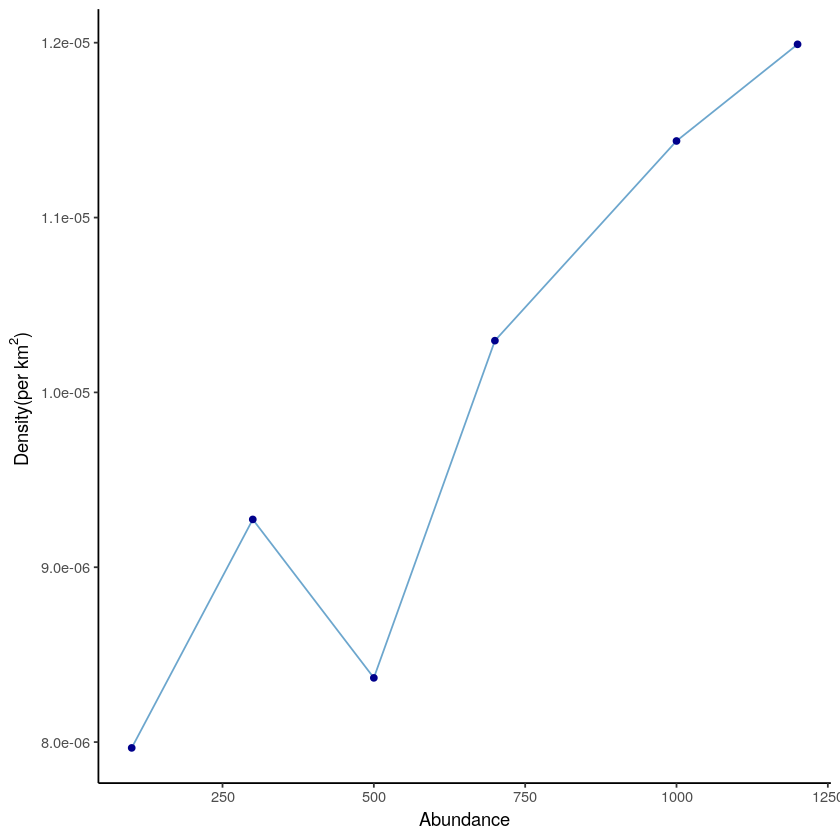

In [30]:
abundance_gen <- function(n, df = all_sims){
    # Randomly select rows to represent abundance
    n <- sample_n(df, n)
    return(n)
}


abundance_density <- function(df){
    z <- sum(df$Actual_hits)
    A <- sum(df$Area_km)
    density <- calcDensity(z, A)
    return(density)
}

#random10 <- abundance_gen(10)
#random30 <- abundance_gen(30)
#random50 <- abundance_gen(50)
#random70 <- abundance_gen(70)
#random100 <- abundance_gen(100)
#random120 <- abundance_gen(120)

abund_table <- function(str_list){
    # Calculate the overall density and standard distribution for subset
    table <- data.frame('Abundance'= 0, 'Density'= 0, 'S_D' = 0)
    for(i in str_list){
        set <- abundance_gen(i)
        density <- abundance_density(set)
        stand_dev <- sd(set$Density_km)
        row <- c(i, density, stand_dev)
        table <- rbind(table, row)
    }
    table <- table[-1,]
    colnames(table) <- c("Abundance", "Density", "SD")
    return(table)
}



abundances <- c(100,300,500,700,1000,1200)

ab <- abund_table(abundances)
#colnames(ab) <- c("Abundance", "Density", "SD")
ab

abund_graph <- ggplot(ab, aes(x = Abundance, y = Density)) +
                    geom_line(colour = 'skyblue3') +
                    geom_point(colour = 'darkblue') +
                    ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                    theme_classic()
abund_graph

In [31]:
pdf(file = paste("../Results/abund_density.pdf"))
print(abund_graph)
dev.off()

png 
  2

,Abundance,Density,SD
,<dbl>,<dbl>,<dbl>
2,100,5.873652e-06,0.0000288335
3,300,9.942319e-06,0.0001165897
4,500,1.184807e-05,0.0001157686
5,700,1.230754e-05,0.0001524540
6,1000,1.203734e-05,0.0001219672
7,1200,1.098154e-05,0.0001299354


In [91]:
library(xtable)
abund_table <- xtable(ab)
print.xtable(abund_table, type = "latex", floating = T, caption.placement = "top", file = "../Results/abund_table.tex",
             include.rownames = F)


**Most of the data is 0 and density for an array of abundances are turning out to be the same. Either :**
1. More simulations
2. Cut out 0s and explore the impact of abundance on density if hits occur.
3. Look at encounter rate instead of density.

Lucas(2015) percentage errors are a bit strange - they go into the minus. I know percentage error is different to the total standard as it takes the distance of each individual estimate to the true mean.

#### Assess density estimates vs. encounter rate

Will the number of hits affect model precision and accuracy?

In [156]:
# For each group of encounters, what was the density calculation and error
# Subset all_sims by number of encounters, counting the amount in that category and the total area
hit_tab <- all_sims %>% 
            group_by(Actual_hits) %>%
                summarise(Encounters = length(Actual_hits),
                          Area = sum(Area_km))

hit_sd <- function(df1, df2){
    s_d <-c()
    for(i in df1$Actual_hits){
        df <- subset(df2, df2$Actual_hits == i)
        stand <- sd(df$Density_km)
        s_d <- c(s_d, stand)
    }
    return(s_d)
}

s_d <- hit_sd(hit_tab, all_sims)
hit_dens <- apply(hit_tab, 1, function(x) calcDensity(x[2],x[3])) # Density = total number of encounters/Area
hit_tab <- cbind(hit_tab, hit_dens)
hit_tab <- cbind(hit_tab, s_d)

hit_error <- sapply(s_d, function(x) x/2)
hit_tab <- cbind(hit_tab, hit_error)        
#hit_tab
                    
hit_tab[is.na(hit_tab)] <- 0
                  
hit_plot <- ggplot(hit_tab, aes(x=Actual_hits, y = hit_dens)) +
                  geom_point(colour="darkblue")+
                  geom_line(colour='skyblue2') +
                  geom_errorbar(aes(ymin=hit_dens-hit_error, ymax = hit_dens+hit_error), width=.15,
                  position=position_dodge(0.05), colour='darkblue') + 
                  xlab("Encounter rate")+
                  ylab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                  theme_classic() 

#pdf(file = paste("../Results/encounters_density.pdf"))
#print(hit_plot)
#dev.off()
#hit_tab <- hit_tab[,-6]
cols <- c('Number of Encounters', 'Frequency', 'Area (km)', 'Density (per km2)', 'Standard Deviation')
colnames(hit_tab) <- cols
hit_tab

png 
  2

Number of Encounters,Frequency,Area (km),Density (per km2),Standard Deviation
<int>,<int>,<dbl>,<dbl>,<dbl>
0,1138062,2.748255e+10,4.141035e-05,0.000000e+00
1,138375,3.335294e+09,4.148810e-05,3.410395e-05
2,51238,9.885461e+08,5.183168e-05,8.266049e-05
3,8650,3.460925e+08,2.499332e-05,7.280198e-05
4,693,7.363399e+06,9.411414e-05,1.146184e-04
5,782,6.640257e+06,1.177665e-04,7.275044e-05
6,762,6.196355e+06,1.229755e-04,6.052904e-05
7,677,5.363215e+06,1.262302e-04,4.066664e-05
8,663,5.256572e+06,1.261278e-04,4.808142e-05


In [89]:
encount_table <- xtable(hit_tab)
print.xtable(encount_table, type = "latex", floating = F, caption.placement = "top", file = "../Results/encount_table.tex",
             include.rownames = F)


In [34]:
53/47

[1] 1.12766

### Impact of variables

Split data into groups to assess how density estimates change with:

1. Area
2. Species
3. Species path
4. Bias
5. Flight path
6. Flight seed

### Point plot analysis

Point plot analysis subsets each variable to attain the number of hits, area, density and standard deviation for that variable set. Boxplot analysis, further down, splits the overall dataset as every value is needed for the IQR of the boxplot.

In [231]:
# Dplyr subset by diffferent categories and compare model precision and accuracy

animal <- all_sims %>% 
            group_by(Animal) %>%
                summarise(Encounters = sum(Actual_hits),
                          Mean_E = mean(Actual_hits),
                          SD_E = sd(Actual_hits))


animal_path <- all_sims %>% 
            group_by(Animal_path) %>%
                summarise(Encounters = sum(Actual_hits),
                          Mean_E = mean(Actual_hits),
                          SD_E = sd(Actual_hits))


camera <- all_sims %>% 
            group_by(Camera) %>%
                summarise(Encounters = sum(Actual_hits),
                          Mean_E = mean(Actual_hits),
                          SD_E = sd(Actual_hits))


uav_path <- all_sims %>% 
            group_by(UAV_path) %>%
                summarise(Encounters = sum(Actual_hits),
                          Mean_E = mean(Actual_hits),
                          SD_E = sd(Actual_hits))


speed <- all_sims %>% 
            group_by(Speed) %>%
                summarise(Encounters = sum(Actual_hits),
                          Ave_E = mean(Actual_hits),
                          Area = sum(Area_km),
                          SD = sd(Density_km),
                          SD_E = sd(Actual_hits))


bias_animals <- c('reef', 'nurse', 'whale_shark', 'ray', 'manatee')
bias_all_sims <- subset(all_sims, all_sims$Animal == bias_animals)

bias <- bias_all_sims %>% 
            group_by(Bias) %>%
                summarise(Encounters = sum(Actual_hits),
                          Ave_E = mean(Actual_hits),
                          Area = sum(Area_km),
                          SD = sd(Density_km),
                          SD_E = sd(Actual_hits))



# Calculate density for each subsetted variable
variables <- list(animal, animal_path, camera, uav_path, speed, bias)
df_list <- list()
for(i in 1:length(variables)){
    c <- as.data.frame(variables[i])
    sub_c <- cbind(c[,2], c[,4]) # Make sure column index indicates encounters and area
    #print(sub_c)
    hit_dens <- apply(sub_c, 1, function(x) calcDensity(x[1], x[2]))
    #print(hit_dens)
    c <- cbind(c, hit_dens)
    df_list <- c(df_list, list(c))
    #i <- cbind(i, s_d)
}
 
# Seperate back into dataframes for analysis
animal <- as.data.frame(df_list[1])
animal_path <- as.data.frame(df_list[2])
camera <- as.data.frame(df_list[3])
uav_path <- as.data.frame(df_list[4])
speed <- as.data.frame(df_list[5])
speed$Speed <- as.character(speed$Speed) # Speed level as factor not integer
bias <- as.data.frame(df_list[6])

speed
sum(animal_path$Encounters)

Speed,Encounters,Ave_E,Area,SD,SD_E,hit_dens
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,199578,0.2969911,7460600000,1.485189e-04,1.1883478,2.675093e-05
2,140607,0.2092366,24754800000,1.797917e-05,0.5583953,5.679989e-06


[1] 340185

### Point Plots: Density at Each Variable Level

In [168]:
den_point <- function(df, name){
    plot <-  ggplot(df, aes(x=df[,1], y = hit_dens)) +
                  geom_point(colour="darkblue")+
                  geom_line(colour='skyblue2') +
                  geom_errorbar(aes(ymin=hit_dens-(SD/2), ymax = hit_dens+(SD/2)), width=.15,
                  position=position_dodge(0.05), colour='darkblue') +
                  labs(x=name, y = "Density") +
                  theme_bw() 
    return(plot)
}

Den_point_ani <- den_point(animal, "Animal")
Den_point_anip <- den_point(animal_path, "Movement Model")
Den_point_cam <- den_point(camera, "Camera")
Den_point_uavp <- den_point(uav_path, "UAV Route")
Den_point_spee <- den_point(speed, "Speed Level")
Den_point_bias <- den_point(bias, 'Bias')

#Den_point_uavp

### Bar Plots: Number of Encounters and Encounter Rate at Each Variable Level

In [237]:
numb_E_bar <- function(df, name){
    plot <-  ggplot(df, aes(x=df[,1], y = Encounters)) +
                  geom_bar(stat='identity', fill="turquoise4") +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='darkblue') +
                  labs(x= name, y = "Number of Encounters") +
                  theme_bw() 
    return(plot)
}

#tot_E_ani <- numb_E_bar(animal, "Animal")
#tot_E_anip <- numb_E_bar(animal_path, "Movement Model")
#tot_E_cam <- numb_E_bar(camera, "Camera")
#tot_E_uavp <- numb_E_bar(uav_path, "UAV Route")
#tot_E_spee <- numb_E_bar(speed, "Speed Level")
#tot_E_bias <- numb_E_bar(bias, "Bias")

animal_labels <- c("B", "F", "M", "N", "Y", "R", "T", "W")
tot_E_ani <- ggplot(animal, aes(x=Animal, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1") +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  theme_bw() +
                  ylab('Number of Encounters') +
                  scale_x_discrete(labels= animal_labels)


labels <- c("R12", "R18", "R6", "25", "50", "75", "S")
tot_E_anip <- ggplot(animal_path, aes(x=Animal_path, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1") +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  theme_bw()+
                  xlab('Animal Movement Model') +
                  theme(axis.title.y=element_blank()) +
                  scale_x_discrete(labels= labels)

tot_E_cam <- ggplot(camera, aes(x=Camera, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1", width = 0.5) +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  theme_bw() +
                  xlab('Camera Model') +
                  theme(axis.title.y=element_blank())

tot_E_uavp <- ggplot(uav_path, aes(x=UAV_path, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1", width = 0.5) +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  xlab('UAV Path') +
                  ylab('Number of Encounters') +
                  theme_bw()

tot_E_spee <- ggplot(speed, aes(x=Speed, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1", width = 0.5) +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  theme_bw() +
                  xlab('Speed Level') +
                  theme(axis.title.y=element_blank())

tot_E_bias <- ggplot(bias, aes(x=Bias, y = Encounters)) +
                  geom_bar(stat='identity', fill="steelblue1", width = 0.5) +
                  geom_errorbar(aes(ymin=Encounters-(SD_E/2), ymax = Encounters+(SD_E/2)), width=.15,
                  position=position_dodge(0.05), colour='blue') +
                  xlab('Animal Availability') +
                  theme_bw() +
                  theme(axis.title.y=element_blank())

#grid.arrange(tot_E_ani, tot_E_anip, tot_E_cam, tot_E_uavp, tot_E_spee, tot_E_bias, ncol=3)
pdf(file = paste("../Results/combo_encounters.pdf"))
print(grid.arrange(tot_E_ani, tot_E_anip, tot_E_cam, tot_E_uavp, tot_E_spee, tot_E_bias, ncol=3))
dev.off()

TableGrob (2 x 3) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (2-2,1-1) arrange gtable[layout]
5 5 (2-2,2-2) arrange gtable[layout]
6 6 (2-2,3-3) arrange gtable[layout]


png 
  2

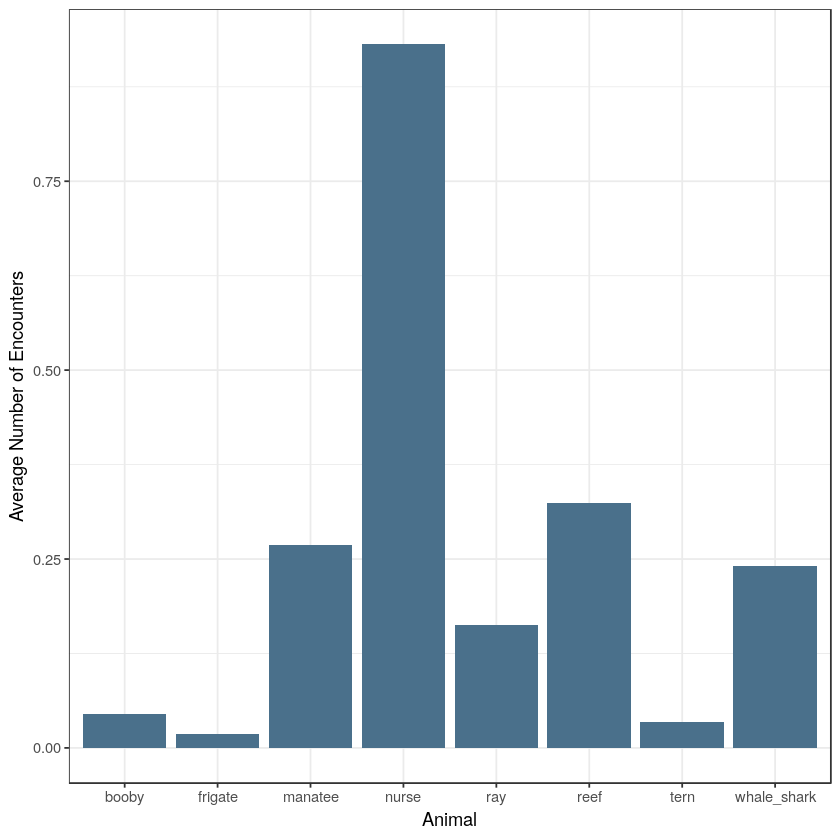

In [217]:
ave_E_bar <- function(df, name){
    plot <-  ggplot(df, aes(x=df[,1], y = Ave_E)) +
                  geom_bar(stat='identity', fill="skyblue4") +
                  #geom_errorbar(aes(ymin=Ave_E-(SD_E/2), ymax = Ave_E+(SD_E/2)), width=.15,
                  #position=position_dodge(0.05), colour='darkblue') +
                  labs(x= name, y = "Average Number of Encounters") +
                  theme_bw() 
    return(plot)
}

mean_E_ani <- ave_E_bar(animal, "Animal")
mean_E_anip <- ave_E_bar(animal_path, "Movement Model")
mean_E_cam <- ave_E_bar(camera, "Camera")
mean_E_uavp <- ave_E_bar(uav_path, "UAV Route")
mean_E_spee <- ave_E_bar(speed, "Speed Level")
mean_E_bias <- ave_E_bar(bias, "Bias")

mean_E_ani

# SD is huge because of the 0 to 145 range in number of hits.

In [152]:
require(gridExtra) # also loads grid
require(lattice)

#pdf(file = paste("../Results/combo_density.pdf"))
#print(grid.arrange(ani_box,anip_box, camera_box, uavp_box, spee_box, bias_box, ncol=3))
#dev.off()

TableGrob (2 x 3) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (2-2,1-1) arrange gtable[layout]
5 5 (2-2,2-2) arrange gtable[layout]
6 6 (2-2,3-3) arrange gtable[layout]


png 
  2

**Next, for obvious patterns in the data start subsetting combinations. Example, nurse shark has highest number of encounters - is it consistent or does it vary with another variable? One Way ANOVA I think

In [100]:
bias

Bias,mean_den,SD
<chr>,<dbl>,<dbl>
no,2.166120e-05,1.137241e-04
yes,1.703725e-05,9.882144e-05


In [98]:
# Desnity within different variable groups is different
# All groups measured teh same amount of times (same parameters and runs)

ano_mod <- function(pos){
    x <- all_sims[,pos]
    model <- lm(Density_km ~ x, data = all_sims)
    print(summary(model))
    an_mod <- anova(model)
    print(an_mod)
    return(an_mod)
}

#ani_mod <- lm(Density_km ~ Animal, data = all_sims)
#summary(ani_mod)
#anova(ani_mod)

ani_ano <- ano_mod(3)
anip_ano <- ano_mod(4)
cam_ano <- ano_mod(1)
uavp_ano <- ano_mod(5)
spee_ano <- ano_mod(2)
bias_ano <- ano_mod(6)



Call:
lm(formula = Density_km ~ x, data = all_sims)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0003979 -0.0001551 -0.0000200 -0.0000028  0.0042448 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.004e-05  6.956e-06   2.881  0.00396 ** 
xfrigate     -1.721e-05  9.838e-06  -1.750  0.08018 .  
xmanatee      1.344e-04  9.838e-06  13.657  < 2e-16 ***
xnurse        3.778e-04  9.838e-06  38.404  < 2e-16 ***
xray         -2.004e-05  9.838e-06  -2.037  0.04162 *  
xreef         1.856e-04  9.838e-06  18.867  < 2e-16 ***
xtern        -6.412e-06  9.838e-06  -0.652  0.51458    
xwhale_shark  1.351e-04  9.838e-06  13.731  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0003492 on 20152 degrees of freedom
Multiple R-squared:  0.1227,	Adjusted R-squared:  0.1224 
F-statistic: 402.6 on 7 and 20152 DF,  p-value: < 2.2e-16

Analysis of Variance Table

Response: Density_km
       

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
x,7,0.0003436757,4.909653e-05,402.6119,0
Residuals,20152,0.0024574368,1.219451e-07,NA,NA
